In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Activation, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
tf.config.threading.set_inter_op_parallelism_threads(6)
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [2]:

import pandas as pd
import numpy as np

df=pd.read_csv("processed data new\\sep_selected_laws_train_new_encoded.csv")
df.drop(columns = ["Unnamed: 0"], inplace= True)
df

,law_area_0,law_area_1,law_area_2,law_area_3,law_area_4,language_0,language_1,language_2,facts_0,facts_1,...,laws_231,laws_232,laws_233,laws_234,laws_235,laws_236,laws_237,laws_238,laws_239,laws_240
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.015351,-0.026758,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.005716,-0.040029,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.025519,-0.022643,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000465,-0.037652,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.020556,-0.038797,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81201,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.000018,-0.023062,...,0,0,0,0,0,0,0,0,0,0
81202,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.007661,-0.017937,...,0,0,0,0,0,0,0,0,0,0
81203,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.033467,-0.025747,...,0,0,0,0,0,0,0,0,0,0
81204,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.002088,-0.020699,...,0,0,0,0,0,0,0,0,0,0


In [3]:
law_area_train= df.values[:,0:5]
language_train = df.values[:,5:8]
facts_train= df.values[:,8:776]
considerations_train= df.values[:,776:1544]
laws_train= df.values[:,1544:]


In [4]:
df = pd.read_csv('processed data new\\sep_selected_laws_test_new_encoded.csv')
df

,law_area_0,law_area_1,law_area_2,law_area_3,law_area_4,language_0,language_1,language_2,facts_0,facts_1,...,laws_231,laws_232,laws_233,laws_234,laws_235,laws_236,laws_237,laws_238,laws_239,laws_240
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.019240,-0.015930,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.012180,-0.050890,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.031751,-0.037796,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.005475,-0.025251,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.047793,-0.032956,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8896,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.006010,-0.000475,...,0,0,0,0,0,0,0,0,0,0
8897,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.024508,-0.036798,...,0,0,0,0,0,0,0,0,0,0
8898,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.008669,-0.035200,...,0,0,0,0,0,0,0,0,0,0
8899,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.003880,-0.018592,...,0,0,0,0,0,0,0,0,0,0


In [5]:
law_area_test= df.values[:,0:5]
language_test = df.values[:,5:8]
facts_test= df.values[:,8:776]
considerations_test= df.values[:,776:1544]
laws_test= df.values[:,1544:]

In [6]:
del df

In [11]:
def compute_class_weights(y):
    n_samples, n_classes = y.shape
    weights = np.ones(n_classes)

    for i in range(n_classes):
        y_col = y[:, i]
        pos = np.sum(y_col)
        if pos == 0 or pos == n_samples:
            continue
        weights[i] = (n_samples / (n_classes * pos))      #for correct propotion, 1=(10/2*5).

    return weights

class_weights = compute_class_weights(laws_train)

In [7]:
import math

def compute_equal_contribution_weights(y):
    n_samples, n_classes = y.shape
    weights = np.ones(n_classes)

    counts = np.sum(y, axis=0)  # count of positive labels per class
    valid = (counts > 0) & (counts < n_samples)

    max_count = np.max(counts[valid])

    for i in range(n_classes):
        if valid[i]:
            weights[i] = math.pow(max_count / counts[i], 1.1)  # make max = 1, others > 1
        else:
            weights[i] = 1  # constant or empty class, skip weighting

    return (weights, counts)

class_weights, freq = compute_equal_contribution_weights(laws_train)

In [8]:
print(class_weights)

[1.00000000e+00 1.00000000e+00 1.00000000e+00 3.35593108e+00
 3.35593108e+00 3.35593108e+00 6.08593507e+00 6.08593507e+00
 6.08593507e+00 6.13994024e+00 6.13994024e+00 6.13994024e+00
 6.74886886e+00 6.74886886e+00 6.74886886e+00 6.95015084e+00
 6.95015084e+00 6.95015084e+00 8.96166795e+00 8.96166795e+00
 8.96166795e+00 9.76078075e+00 9.76078075e+00 9.76078075e+00
 1.17174030e+01 1.17174030e+01 1.17174030e+01 1.96966833e+01
 1.96966833e+01 1.96966833e+01 2.11780761e+01 2.11780761e+01
 2.11780761e+01 2.36629272e+01 2.36629272e+01 2.36629272e+01
 2.57119310e+01 2.57119310e+01 2.57119310e+01 2.71257661e+01
 2.71257661e+01 2.71257661e+01 3.21679475e+01 3.21679475e+01
 3.21679475e+01 3.48229316e+01 3.48229316e+01 3.48229316e+01
 4.50517512e+01 4.50517512e+01 4.50517512e+01 4.66564305e+01
 4.66564305e+01 4.66564305e+01 5.03459514e+01 5.03459514e+01
 5.03459514e+01 6.23559428e+01 6.23559428e+01 6.23559428e+01
 6.39599391e+01 6.39599391e+01 6.39599391e+01 6.58611414e+01
 6.58611414e+01 6.586114

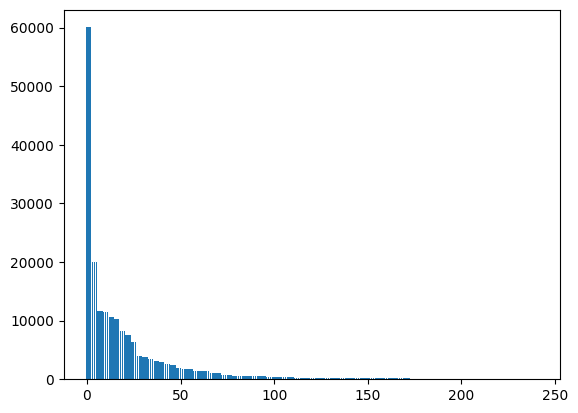

In [8]:
import matplotlib.pyplot as plt 

plt.bar(range(241), freq.tolist())
plt.show()

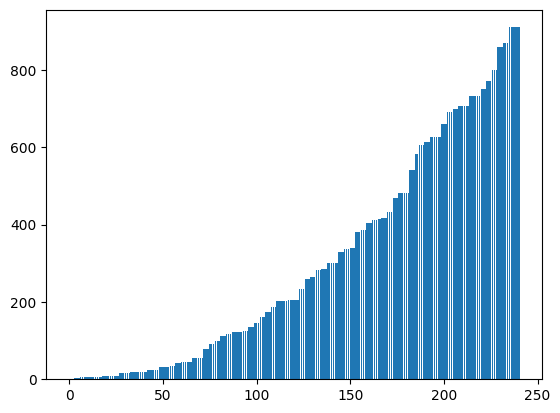

In [9]:
import matplotlib.pyplot as plt 

plt.bar(range(241), class_weights.tolist())
plt.show()

In [9]:
w = tf.constant(class_weights, dtype=tf.float32)

@tf.keras.utils.register_keras_serializable()
def weighted_bce(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    loss = - w * (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    #loss = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))


In [10]:
#average(class) recall

@tf.keras.utils.register_keras_serializable()
def avg_recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
    
    recall = tf.math.divide_no_nan(tp, tp + fn)
    return tf.reduce_mean(recall)

@tf.keras.utils.register_keras_serializable()
def avg_precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    
    precision = tf.math.divide_no_nan(tp, tp + fp)
    return tf.reduce_mean(precision)


In [11]:
#weighted(class) recall

@tf.keras.utils.register_keras_serializable()
def wei_recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
    
    recall = tf.math.divide_no_nan(tp, tp + fn)
    return tf.reduce_sum((w / tf.reduce_sum(w)) * recall)

@tf.keras.utils.register_keras_serializable()
def wei_precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    
    precision = tf.math.divide_no_nan(tp, tp + fp)
    return tf.reduce_sum((w / tf.reduce_sum(w)) * precision)


In [13]:
#individual recall

def ind_recall(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=0)
    
    recall = tf.math.divide_no_nan(tp, tp + fn)
    return recall


def ind_precision(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=0)
    
    precision = tf.math.divide_no_nan(tp, tp + fp)
    return precision


In [13]:
ep=500
bs=512

reg = l2(0.08)

input_1 = Input(shape=(5,), name='law_area')
input_2 = Input(shape=(3,), name='language')
input_3 = Input(shape=(768,), name='facts')
input_4 = Input(shape=(768,), name='considerations')

b1 = Dense(600, kernel_regularizer=reg, name='facts_dense1')(input_3)
b1 = LeakyReLU(alpha=0.1)(b1)
b1 = Dropout(0.3)(b1)
b1 = Dense(450, kernel_regularizer=reg, name='facts_dense2')(b1)
b1 = LeakyReLU(alpha=0.1)(b1)
b1 = Dropout(0.3)(b1)

b2 = Dense(600, kernel_regularizer=reg, name='considerations_dense1')(input_4)
b2 = LeakyReLU(alpha=0.1)(b2)
b2 = Dropout(0.3)(b2)
b2 = Dense(450, kernel_regularizer=reg, name='considerations_dense2')(b2)
b2 = LeakyReLU(alpha=0.1)(b2)
b2 = Dropout(0.3)(b2)

merged = Concatenate()([input_1, input_2, b1, b2])

output = Dense(700, kernel_regularizer=reg, name='concatenate_dense1')(merged)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.3)(output)

output = Dense(500, kernel_regularizer=reg, name='concatenate_dense2')(output)
output = BatchNormalization()(output)
output = Activation('relu')(output)
output = Dropout(0.3)(output)

output = Dense(241, activation='sigmoid', name='output_layer')(output)

model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)        #change this accordingly
model.compile(loss=weighted_bce, optimizer='adam', metrics=[avg_recall, avg_precision, wei_recall, wei_precision])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ facts (InputLayer)  │ (None, 768)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ considerations      │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ facts_dense1        │ (None, 600)       │    461,400 │ facts[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ considerations_den… │ (None, 600)       │    461,400 │ considerations[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 600)       │          0 │ facts_dense1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 600)       │          0 │ considerations_d… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 600)       │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 600)       │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ facts_dense2        │ (None, 450)       │    270,450 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ considerations_den… │ (None, 450)       │    270,450 │ dropout_8[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 450)       │          0 │ facts_dense2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 450)       │          0 │ considerations_d… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ law_area            │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ language            │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 450)       │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 450)       │          0 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 908)       │          0 │ law_area[0][0],   │
│ (Concatenate)       │                   │            │ language[0][0],   │
│                     │                   │            │ dropout_7[0][0],  │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_dense1  │ (None, 700)       │    636,300 │ concatenate_1[0]

 Total params: 2,576,041 (9.83 MB)

 Trainable params: 2,573,641 (9.82 MB)

 Non-trainable params: 2,400 (9.38 KB)

import ast
#import multiprocessing

def worker(cokumn):
    return np.array(cokumn.map(ast.literal_eval).values.tolist())

if __name__ == "__main__":
    data = [df_train['onehot_language'], df_train['onehot_law_area'], df_train['encoded_facts'], df_train['encoded_considerations'], df_train['onehot_laws']]
    
    with multiprocessing.Pool() as pool:
        results = pool.map(worker, data)
    
    train_lanugage, train_law_area, train_facts, train_considerations, train_laws= results


    data = [df_val['onehot_language'], df_val['onehot_law_area'], df_val['encoded_facts'], df_val['encoded_considerations'], df_val['onehot_laws']]
    
    with multiprocessing.Pool() as pool:
        results = pool.map(worker, data)
    
    lanugage_val, law_area_val, facts_val, considerations_val, laws_val= results


In [ ]:
h = model.fit(
    [law_area_train, language_train, facts_train, considerations_train],
    laws_train,
    epochs=ep,
    batch_size=bs,
    callbacks=[tensorboard_callback],            #tensorboard --logdir logs/fit and http://localhost:6006,
    validation_data=([law_area_test, language_test, facts_test, considerations_test],laws_test)
)

In [ ]:
model.save("models\\final_model.keras")